In [4]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append(os.path.abspath('..'))
from shared import generate


# *Blunt Scenario*

### **Data Generation**

In [191]:
def generate_blunt_dialogue():
  return generate(model = 'gpt-4o',
        system = '''Generate dialogues as specified below.''',
        query = ''' Create 100 different and independent two-message dialogues. In each dialogue, the first message must be from Speaker 1 — e.g., a suggestion, observation, or opinion. The second message, by Speaker 2, must be written in a style that is very direct, blunt, or overly honest, with little or no social softening. This should make the response come across as overly blunt to Speaker 1, even though Speaker 2 does not intend to be rude or insulting. Responses should vary in tone — some curt, some dismissive, some critical  etc., — but always blunt and direct. Output a single Python list of 100 dictionaries; each dictionary must have exactly this formatting: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."},...]

Do not generate Markdown or fenced code blocks. Here are some examples to guide you:

[
  {"Speaker 1": "We could watch the new Marvel movie tonight.", "Speaker 2": "Honestly, I’ve had enough of superhero films lately. They all feel repetitive to me, so I’d rather not."},
  {"Speaker 1": "I finally finished my first draft of the presentation.", "Speaker 2": "Right now, it comes across as disorganized and hard to follow. You’ll need to restructure it a lot."},
  {"Speaker 1": "I was thinking of baking cookies for the sports team tomorrow.", "Speaker 2": "That’s unnecessary. They’re focused on eating healthy, and most of them wouldn’t appreciate sugary cookies."}
]
''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)



In [192]:
blunt_statements = []
while(len(blunt_statements) < 100):
    output = ast.literal_eval(generate_blunt_dialogue()['response'])
    blunt_statements = output + blunt_statements

blunt_statements = blunt_statements[0:100] 


In [193]:
blunt_statements[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [194]:
with open('../blunt_generated_data/blunt.json', 'w') as f:
    json.dump(blunt_statements, f, indent=2)


### **Identify and Explain Issue**


In [334]:
def identify_explain_blunt(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [335]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [336]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = identify_explain_blunt(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [337]:
with open('../blunt_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [338]:
with open('../blunt_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 2 dismisses speaker 1's suggestion in a negative and absolute manner by saying they 'really don't like sushi' and that it 'tastes bad and is overpriced.' This response could be seen as harsh and uncooperative, shutting down the conversation rather than expressing their own preference in a more constructive way. They could improve their communication by acknowledging speaker 1's suggestion and expressing their personal preferences in a more respectful and open manner. For example, they might suggest an alternative cuisine or restaurant that they both might enjoy."},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 2's response is dismissive and lacks constructive feedback. Instead of outrightly rejecting Speaker 1's idea, Speaker 2 could offer more informative and supportive reasons why a snake might not be suitable for beginners and suggest alternative pets that might be a better fit. This approach would be more helpful and encourage p

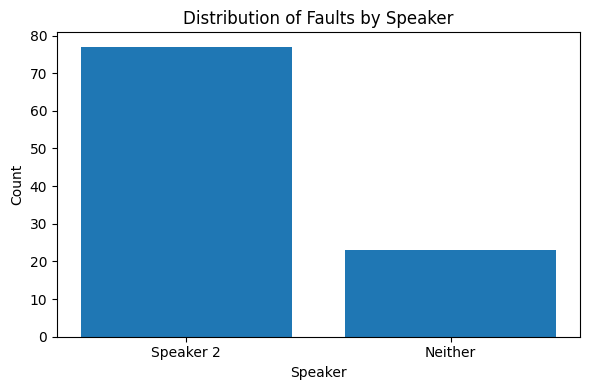

In [339]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [340]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [341]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [342]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [343]:
with open('../blunt_analysis_data/provide_feedback_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [344]:
with open('../blunt_analysis_data/provide_feedback_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'feedback': "Speaker 2 could provide a more constructive response by suggesting an alternative. For example, they could say, 'I’m not a fan of sushi. How about we try the new Italian place instead?'"},
 {'feedback': "Speaker 2's response is dismissive and doesn't encourage further discussion. It would be better to provide constructive feedback or ask questions to understand Speaker 1's reasoning and share knowledge positively. For example, 'Why are you considering a snake as a pet?', or 'Snakes can be challenging pets for beginners; have you looked into their specific care requirements?'"}]

### **Autistic vs Non-autistic Chances**


In [566]:
def autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [551]:
# def autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [567]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    


In [568]:

blunt_statements_generated[0:2]

[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [569]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(response)
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [570]:
results[0:2]

[{'chance': 'medium',
  'explanation': "The directness and candor of Speaker 2's response can be more common in autistic communication, where there is often a preference for honest and straightforward expression over social conventions. However, this type of statement can also easily be made by non-autistic individuals who simply have a strong preference or opinion about sushi."},
 {'chance': 'medium',
  'explanation': 'The statement from Speaker 2 is direct and blunt, which can be a communication style more commonly associated with autistic individuals who may prioritize facts over social niceties. However, it is also possible for non-autistic individuals to make direct statements, especially if they feel strongly about the topic. Therefore, the chance is considered medium.'}]

In [571]:
with open('../blunt_analysis_data/autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [572]:
def non_autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [541]:
# def non_autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [573]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    


In [574]:

blunt_statements_generated[0:2]

[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [575]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = non_autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [576]:
results[0:2]

[{'chance': 'medium',
  'explanation': "Speaker 2's statement is direct and clear about their dislike for sushi. While direct communication can sometimes be associated with autistic individuals, it is also common among non-autistic individuals, especially in casual conversations. Therefore, the chance is medium."},
 {'chance': 'medium',
  'explanation': "While non-autistic people may also express strong opinions about pet choices, the directness and lack of sugar-coating in Speaker 2's response is often more characteristic of communication styles associated with autistic individuals. However, this does not mean a non-autistic person wouldn't also say such a thing, hence the chance is medium."}]

In [577]:
with open('../blunt_analysis_data/non_autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [578]:
with open('../blunt_analysis_data/autistic_chances_ctx_none.json') as f:
    autistic_results_loaded = json.load(f)

autistic_results_loaded[0:2]


[{'chance': 'medium',
  'explanation': "The directness and candor of Speaker 2's response can be more common in autistic communication, where there is often a preference for honest and straightforward expression over social conventions. However, this type of statement can also easily be made by non-autistic individuals who simply have a strong preference or opinion about sushi."},
 {'chance': 'medium',
  'explanation': 'The statement from Speaker 2 is direct and blunt, which can be a communication style more commonly associated with autistic individuals who may prioritize facts over social niceties. However, it is also possible for non-autistic individuals to make direct statements, especially if they feel strongly about the topic. Therefore, the chance is considered medium.'}]

In [579]:
with open('../blunt_analysis_data/non_autistic_chances_ctx_none.json') as f:
    non_autistic_results_loaded = json.load(f)

non_autistic_results_loaded[0:2]


[{'chance': 'medium',
  'explanation': "Speaker 2's statement is direct and clear about their dislike for sushi. While direct communication can sometimes be associated with autistic individuals, it is also common among non-autistic individuals, especially in casual conversations. Therefore, the chance is medium."},
 {'chance': 'medium',
  'explanation': "While non-autistic people may also express strong opinions about pet choices, the directness and lack of sugar-coating in Speaker 2's response is often more characteristic of communication styles associated with autistic individuals. However, this does not mean a non-autistic person wouldn't also say such a thing, hence the chance is medium."}]

Total pairs considered: 100
Valid, aligned pairs kept: 100
Dropped pairs: 0


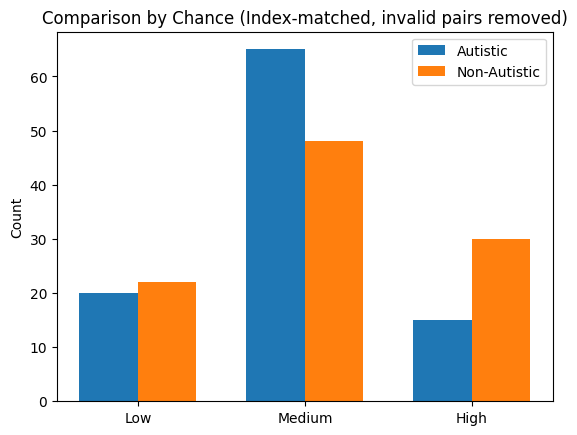

In [580]:
valid_values = {"low", "medium", "high"}

def get_chance(d):
    """Return normalized 'chance' string or None if missing/invalid."""
    v = d.get("chance", None)
    if not isinstance(v, str):
        return None
    v = v.strip().lower()
    return v if v in valid_values else None

# Index-matched filtering: keep only pairs where BOTH sides are valid
paired_valid = []
n_pairs = min(len(autistic_results_loaded), len(non_autistic_results_loaded))
for a_dict, b_dict in zip(autistic_results_loaded[:n_pairs], non_autistic_results_loaded[:n_pairs]):
    a = get_chance(a_dict)
    b = get_chance(b_dict)
    if a is not None and b is not None:
        paired_valid.append((a, b))

# Split back into two aligned lists
autistic_clean = [a for a, _ in paired_valid]
non_autistic_clean = [b for _, b in paired_valid]

print("Total pairs considered:", n_pairs)
print("Valid, aligned pairs kept:", len(paired_valid))
print("Dropped pairs:", n_pairs - len(paired_valid))

# Counts
categories = ["low", "medium", "high"]
autistic_counts = Counter(autistic_clean)
non_autistic_counts = Counter(non_autistic_clean)

autistic_values = [autistic_counts.get(cat, 0) for cat in categories]
non_autistic_values = [non_autistic_counts.get(cat, 0) for cat in categories]

# Plot (grouped bars)
x = range(len(categories))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], autistic_values, width=bar_width, label="Autistic")
plt.bar([i + bar_width/2 for i in x], non_autistic_values, width=bar_width, label="Non-Autistic")

plt.xticks(x, [c.capitalize() for c in categories])
plt.ylabel("Count")
plt.title("Comparison by Chance (Index-matched, invalid pairs removed)")
plt.legend()
plt.show()